# GNNExplainer

In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
from torch_geometric.loader import DataLoader
from torch.optim import AdamW
from utils.data import (
    load_dataframes,
    summary_statistics,
)
from exploration.graph_creation import *
from models.graphensemble.multigraph import *
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig
from torch_geometric.utils import to_networkx
from exploration.get_graphs_and_data import *
from exploration.explainability_utils import *

/home/ltchen/gnnpp


In [2]:
leadtime = "24h"
graph_name = "g1"
# data_type = "f"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name)
with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/params.json
Loading precomputed graph data...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_f = torch.load(test_f_path)


In [3]:
g1_train_loader = DataLoader(g_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(g_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(g_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(g_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = g_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = g_train_rf[0].num_edge_features
num_nodes = g_train_rf[0].num_nodes

In [4]:
TRAINNAME = f"{graph_name}_{leadtime}_train_run7"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')

In [5]:
multigraph = load_gnn_model(CKPT_PATH, num_nodes, emb_dim, edge_dim, in_channels, config)
graph_to_explain = g_train_rf[0]

In [121]:
multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
node_idx = 11  # 10



In [ ]:
mexplainer = create_explainer(multigraph)
# do a few times monte carlo
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                         edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

In [109]:
# for every run
feature_loc = torch.nonzero(explanation.node_mask, as_tuple=False) # feature_loc.shape = 384 (64*6), 2 (node, feature)
# print(feature_loc)
# print(feature_loc.shape)
feature_tuples = [tuple(row.tolist()) for row in node_idx]
# print(explanation.node_mask.shape)
node_weights = explanation.node_mask[explanation.node_mask != 0]


    run_id node feature    weight
0        0    8       1  0.385707
1        0    8       2  0.572201
2        0    8       3  0.335959
3        0    8       4  0.306432
4        0    8       5  0.317012
..     ...  ...     ...       ...
379      0   16      60  0.265865
380      0   16      61  0.353959
381      0   16      62  0.290903
382      0   16      63  0.395309
383      0   16      64  0.249660

[384 rows x 4 columns]


In [123]:
df = pd.DataFrame(columns=['run_id', 'node', 'feature', 'weight'])

for run_id in range(3):
    mexplainer = create_explainer(multigraph)
    explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                             edge_attr=graph_to_explain.edge_attr, index=node_idx)
    print(f'Generated explanations in {explanation.available_explanations}')

    feature_loc = torch.nonzero(explanation.node_mask, as_tuple=False) # feature_loc.shape = 384 (64*6), 2 (node, feature)
    # feature_tuples = [tuple(row.tolist()) for row in feature_loc]
    node_weights = explanation.node_mask[explanation.node_mask != 0]
    print(node_weights.shape)
    new_df = pd.DataFrame({
        'run_id': run_id,
        'node': feature_loc[:, 0].numpy(),
        'feature': feature_loc[:, 1].numpy(),
        'weight': node_weights.numpy()
    })
    df = pd.concat([df, new_df], ignore_index=True)
print(df)

Generated explanations in ['edge_mask', 'node_mask']
torch.Size([384])
Generated explanations in ['edge_mask', 'node_mask']
torch.Size([384])
Generated explanations in ['edge_mask', 'node_mask']
torch.Size([384])
     run_id node feature    weight
0         0    8       1  0.517579
1         0    8       2  0.480543
2         0    8       3  0.222396
3         0    8       4  0.279681
4         0    8       5  0.287846
...     ...  ...     ...       ...
1147      2   16      60  0.511772
1148      2   16      61  0.272979
1149      2   16      62  0.291997
1150      2   16      63  0.395698
1151      2   16      64  0.274344

[1152 rows x 4 columns]


In [130]:
pivoted_df = df.pivot_table(
    index=['node', 'feature'],
    columns='run_id',
    values='weight'
)
pivoted_df

run_id               0         1         2
node feature                              
8    1        0.517579  0.552087  0.469573
     2        0.480543  0.466950  0.477232
     3        0.222396  0.292725  0.272059
     4        0.279681  0.271744  0.285841
     5        0.287846  0.300525  0.297937
...                ...       ...       ...
16   60       0.312569  0.235644  0.511772
     61       0.271163  0.288136  0.272979
     62       0.287168  0.279032  0.291997
     63       0.415464  0.425296  0.395698
     64       0.293482  0.292963  0.274344

[384 rows x 3 columns]

In [ ]:
df[df['node'] == 8].groupby('feature').mean()

In [76]:
weights_dict = {}
# for each mc run
for i in range(3):
    mexplainer = create_explainer(multigraph)
    explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                             edge_attr=graph_to_explain.edge_attr, index=node_idx)
    print(f'Generated explanations in {explanation.available_explanations}')

    mask_idx = np.where(explanation.edge_mask > 0)
    edge_weights = explanation.edge_mask[mask_idx]
    edge_idx = explanation.edge_index[:,mask_idx].squeeze(1)
    transposed = edge_idx.transpose(0, 1)
    print(transposed.shape)
    tuples = [tuple(row.tolist()) for row in transposed]

    for i in range(len(tuples)):
        weight = edge_weights[i].item()
        key = tuples[i]
        if key in weights_dict:
            weights_dict[key].append([weight])
        else:
            weights_dict[key] = [weight]
    print(weights_dict)

Generated explanations in ['edge_mask', 'node_mask']
torch.Size([5, 2])
{(8, 11): [0.6074721217155457], (9, 11): [0.5779330730438232], (12, 11): [0.6207122206687927], (14, 11): [0.6005917191505432], (16, 11): [0.677038311958313]}
Generated explanations in ['edge_mask', 'node_mask']
torch.Size([5, 2])
{(8, 11): [0.6074721217155457, [0.693930983543396]], (9, 11): [0.5779330730438232, [0.6933021545410156]], (12, 11): [0.6207122206687927, [0.47304365038871765]], (14, 11): [0.6005917191505432, [0.6620810627937317]], (16, 11): [0.677038311958313, [0.7027275562286377]]}
Generated explanations in ['edge_mask', 'node_mask']
torch.Size([5, 2])
{(8, 11): [0.6074721217155457, [0.693930983543396], [0.633672297000885]], (9, 11): [0.5779330730438232, [0.6933021545410156], [0.6197752952575684]], (12, 11): [0.6207122206687927, [0.47304365038871765], [0.6597620844841003]], (14, 11): [0.6005917191505432, [0.6620810627937317], [0.5649610757827759]], (16, 11): [0.677038311958313, [0.7027275562286377], [0.6

Node 11 has 5.0 neighbors


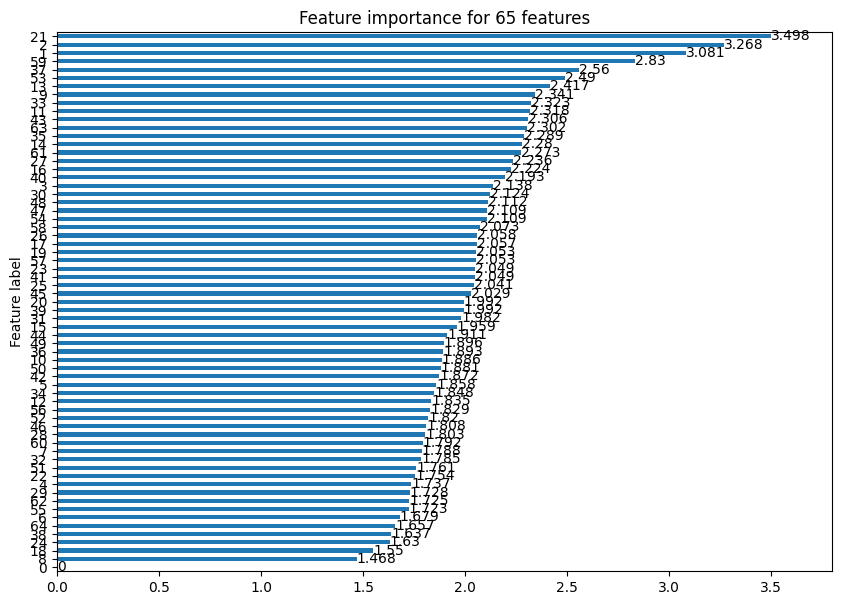

65


In [59]:
degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")
explanation.visualize_feature_importance()
feature_names, grouped = get_feature_list(mode="gnnexplainer")

In [8]:
print(feature_names[61], feature_names[9], feature_names[23], feature_names[13], feature_names[61])

v_std sd_std u10_std swvl1_std v_std


## Old version

In [13]:
dataframes = load_dataframes(leadtime=leadtime)
dataframes = summary_statistics(dataframes)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [17]:
feature_names = [f for f in dataframes['test_f'][0].columns.tolist()] # if f not in ['time', 'number']]
len(feature_names)
feature_names

['time',
 'station_id',
 'model_orography',
 'station_altitude',
 'station_latitude',
 'station_longitude',
 'cape_mean',
 'cape_std',
 'sd_mean',
 'sd_std',
 'stl1_mean',
 'stl1_std',
 'swvl1_mean',
 'swvl1_std',
 't2m_mean',
 't2m_std',
 'tcc_mean',
 'tcc_std',
 'tcw_mean',
 'tcw_std',
 'tcwv_mean',
 'tcwv_std',
 'u10_mean',
 'u10_std',
 'u100_mean',
 'u100_std',
 'v10_mean',
 'v10_std',
 'v100_mean',
 'v100_std',
 'vis_mean',
 'vis_std',
 'cp6_mean',
 'cp6_std',
 'mn2t6_mean',
 'mn2t6_std',
 'mx2t6_mean',
 'mx2t6_std',
 'p10fg6_mean',
 'p10fg6_std',
 'slhf6_mean',
 'slhf6_std',
 'sshf6_mean',
 'sshf6_std',
 'ssr6_mean',
 'ssr6_std',
 'ssrd6_mean',
 'ssrd6_std',
 'str6_mean',
 'str6_std',
 'strd6_mean',
 'strd6_std',
 'tp6_mean',
 'tp6_std',
 'z_mean',
 'z_std',
 'q_mean',
 'q_std',
 'u_mean',
 'u_std',
 'v_mean',
 'v_std',
 't_mean',
 't_std',
 'number']

In [4]:
graph_name = "g1"
drn = False
if drn == True:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/drn_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"trained_models/drn_{leadtime}/params.json")
else:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/params.json")


with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/params.json


In [5]:
graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo"], edges=[("geo", 50)], sum_stats = True)
graphs1_valid_rf, graphs1_test_rf, graphs1_test_f = tests1

g1_train_loader = DataLoader(graphs1_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(graphs1_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(graphs1_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(graphs1_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs1_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs1_train_rf[0].num_edge_features
# max_epochs = max_epoch_list[graph_name]
num_nodes = graphs1_train_rf[0].num_nodes

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3


100%|██████████| 730/730 [00:02<00:00, 254.51it/s]


In [6]:
TRAINNAME = f"{graph_name}_{leadtime}_train_run7"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
# RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")
RESULTPATH = JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}")
print(RESULTPATH)

multigraph = Multigraph.load_from_checkpoint(
    CKPT_PATH,
    num_nodes=num_nodes,
    embedding_dim=emb_dim,
    edge_dim=edge_dim,
    in_channels=in_channels,
    hidden_channels_gnn=config['gnn_hidden'],
    out_channels_gnn=config['gnn_hidden'],
    num_layers_gnn=config['gnn_layers'],
    heads=config['heads'],
    hidden_channels_deepset=config['gnn_hidden'],
    optimizer_class=AdamW,
    optimizer_params=dict(lr=config['lr']),
)
multigraph.eval()
# trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=True)

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h


Multigraph(
  (encoder): EmbedStations(
    (embed): Embedding(120, 20)
  )
  (conv): ResGnn(
    (convolutions): ModuleList(
      (0): GATv2Conv(-1, 256, heads=8)
    )
    (lin): Linear(in_features=2048, out_features=256, bias=True)
    (relu): ReLU()
  )
  (aggr): DeepSetAggregator(
    (input): Linear(in_features=256, out_features=256, bias=True)
    (hidden1): Linear(in_features=256, out_features=256, bias=True)
    (hidden2): Linear(in_features=256, out_features=256, bias=True)
    (output): Linear(in_features=256, out_features=2, bias=True)
    (relu): ReLU()
  )
  (postprocess): MakePositive()
  (loss_fn): NormalCRPS()
)

In [7]:
graph_to_explain = graphs1_train_rf[0]

In [8]:
class MultigraphWrapper(nn.Module):
    def __init__(self, model):
        super(MultigraphWrapper, self).__init__()
        self.model = model
        self.training = model.training
        self.device = next(model.parameters()).device
        self.edge_dim = getattr(model, 'edge_dim', 1)
        # print(self.device)

    def forward(self, x, edge_index, edge_attr=None, **kwargs):
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)
        edge_attr = edge_attr.to(self.device)
        # print(f"x.shape: {x.shape}, device: {x.device}")
        # print(f"edge_index.shape: {edge_index.shape}, device: {edge_index.device}")
        # print(f"edge_attr.shape: {edge_attr.shape}, device: {edge_attr.device}")
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
        )
        data.batch = torch.zeros(x.size(0), dtype=torch.long, device=self.device)
        data.n_idx = torch.arange(x.size(0), device=self.device)
        return self.model(data)

In [22]:
def create_explainer(model):
    # print(model)
    wrapped_model = MultigraphWrapper(model)
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=500, lr=0.002),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=ModelConfig(
            mode='regression',
            task_level='node',
            return_type='raw' # crps? globale wichtigkeit
        )
    )
    return explainer

In [30]:
from torch_geometric.utils import degree

multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
mexplainer = create_explainer(multigraph)
node_idx = 10 # 10
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index, edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")

Generated explanations in ['edge_mask', 'node_mask']
Node 10 has 2.0 neighbors


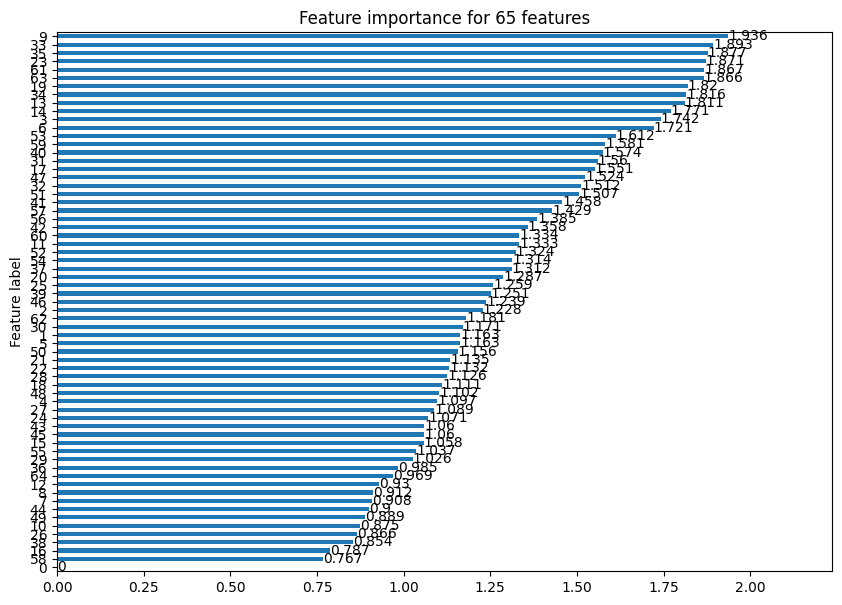

t2m_mean station_latitude mx2t6_mean u100_mean t_mean


In [37]:
explanation.visualize_feature_importance()
feature_names = [f for f in dataframes['test_f'][0].columns.tolist() if f not in ['time', 'number']] # dropped time and number: len - 65
print(feature_names[13], feature_names[3], feature_names[35], feature_names[23], feature_names[61])

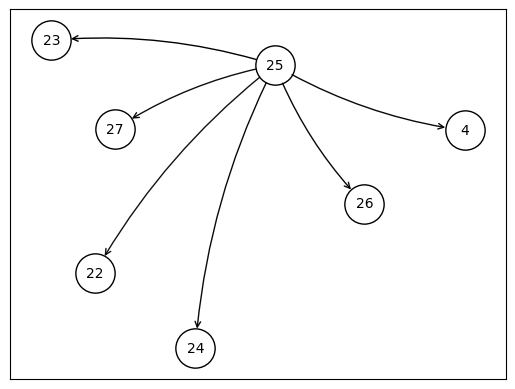

In [78]:
explanation.visualize_graph()
# is station actually only connected to stations 13 and 7?

In [32]:
node_feat_mask = explanation.node_mask.detach().cpu().numpy()
edge_mask = explanation.edge_mask.detach().cpu().numpy()

G = to_networkx(graph_to_explain, to_undirected=True)
nodes = set([node_idx])
neighbors = set(G.neighbors(node_idx))
print(neighbors)
print(nodes)

{13, 7}
{10}


In [33]:
nodes.update(neighbors)
# get neighbors of neighbors
for n in neighbors:
    nodes.update(G.neighbors(n))
print(nodes)
print(neighbors)

subgraph = G.subgraph(nodes)

{3, 5, 7, 10, 12, 13, 15}
{13, 7}


In [34]:
edges = list(subgraph.edges())
# print(edges)
edge_colors = []
edge_widths = []

edge_importance = {}
for i, (src, tgt) in enumerate(graph_to_explain.edge_index.t().tolist()):
    if edge_mask[i] != 0:
        edge_importance[(src, tgt)] = edge_mask[i]
        edge_importance[(tgt, src)] = edge_mask[i]

for edge in edges:
    # print(edge)
    importance = edge_importance.get(edge, 0)
    print(importance)
    if importance > 0:
        edge_colors.append(importance)
        edge_widths.append(1 + 4 * importance)
    else:
        edge_colors.append(0.1)
        edge_widths.append(0.5)

0
0
0.3410892
0.28107765
0
0


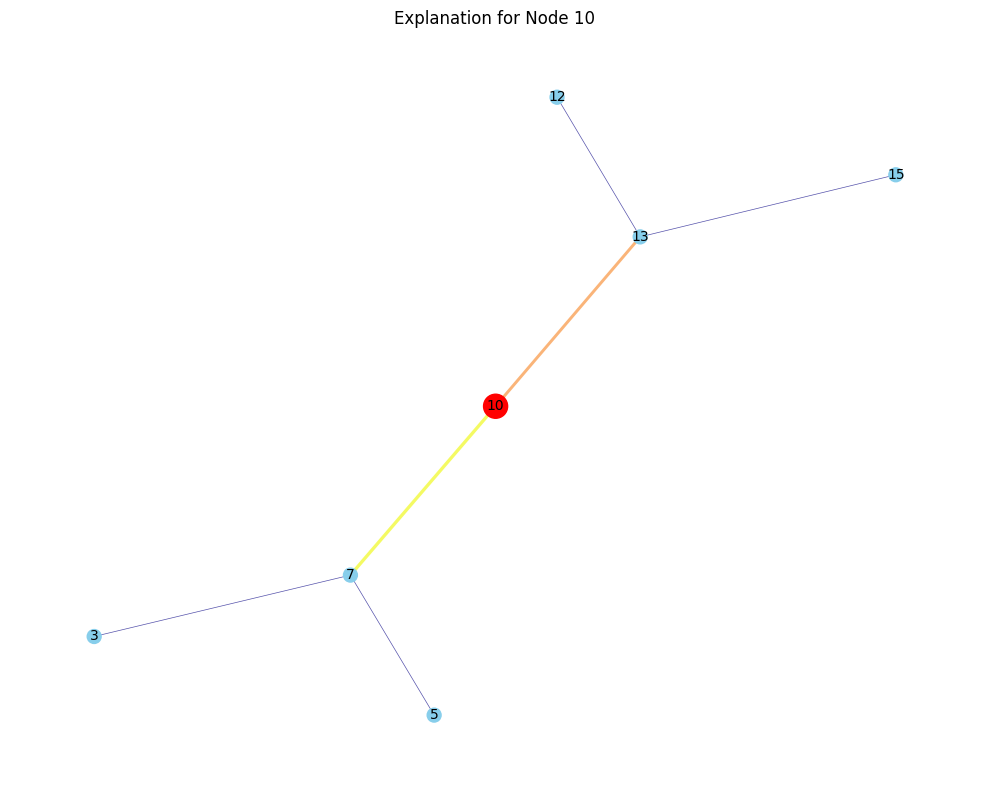

In [35]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_edges(
    subgraph, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    alpha=0.7
)

node_colors = ['red' if n == node_idx else 'skyblue' for n in subgraph.nodes()]
node_sizes = [300 if n == node_idx else 100 for n in subgraph.nodes()]

nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=list(subgraph.nodes()),
    node_color=node_colors,
    node_size=node_sizes
)

nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.axis('off')
plt.title(f'Explanation for Node {node_idx}')
plt.tight_layout()
plt.show()

# auf die Karte plotten
# welche Kanten überhaupt wichtig